# Speech Recognition

This notebook describes the training of a speech recognition system using the data from the [TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data).

We will use logistic regression and revisit this data set with other models.

First we get the data and extract it.

In [1]:
import os
import urllib.request
import tarfile

url = 'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz'
data_files = os.listdir('../data/')

if 'speech_commands_v0.01.tar.gz' not in data_files:
    print('Downloading...')
    urllib.request.urlretrieve(url, '../data/speech_commands_v0.01.tar.gz')
    print('Done!')
else:
    print('Data Available')
    
# unzip
 
if 'yes' not in data_files:
    try:    
        tf = tarfile.open('../data/speech_commands_v0.01.tar.gz')
        tf.extractall('../data/')
    except:
        pass

    
    

Data Available


We now obtain a random file with the word "yes" and plot its waveform and spectrogram

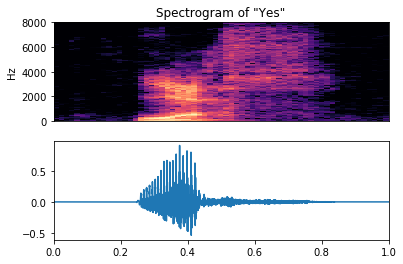

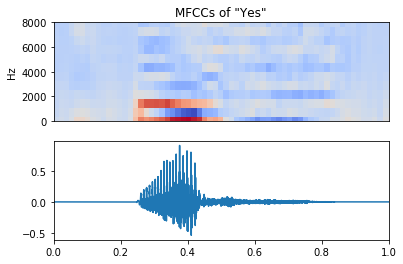

In [2]:
%matplotlib inline
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
import numpy as np
import time


# set up speech processing parameters
NFFT = 512  # 32 ms at 16kHz
HOP_LENGTH = 256 
NUM_MFCC = 13


yes_files = os.listdir('../data/yes')
signal, sampling_rate = librosa.load('../data/yes/' + random.choice(yes_files), sr=None) # use native sampling rate
    
spectrum = np.abs(librosa.stft(signal, n_fft=NFFT, hop_length=HOP_LENGTH))
mfccs = librosa.feature.mfcc(y=signal, sr= sampling_rate, n_mfcc=NUM_MFCC, n_fft=NFFT, hop_length=HOP_LENGTH)
mfccs = mfccs[1:, :]  # discard the zeroeth coefficient which doesn't have much speaker specific information 

plt.figure()
plt.subplot(211)
librosa.display.specshow(librosa.amplitude_to_db(spectrum, ref=np.max),
                         sr=sampling_rate,
                         hop_length=HOP_LENGTH,
                         y_axis='linear', 
                         x_axis='time')
plt.title('Spectrogram of "Yes"')
plt.xticks([])
plt.xlabel('')

plt.subplot(212)
plt.plot(np.arange(len(signal)) / sampling_rate, signal)
plt.xlim([0, 1]);

plt.figure()
plt.subplot(211)
librosa.display.specshow(mfccs,
                         sr=sampling_rate,
                         hop_length=HOP_LENGTH,
                         y_axis='linear', 
                         x_axis='time')
plt.title('MFCCs of "Yes"')
plt.xticks([])
plt.xlabel('')

plt.subplot(212)
plt.plot(np.arange(len(signal)) / sampling_rate, signal)
plt.xlim([0, 1]);

## Dataset preparation

We determine the number of files for each of the words. The core words in the dataset are "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", and "Nine". There are ten auxiliary words: "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila", "Tree", and "Wow".

In [3]:
core_words = ['yes', 'no', 'up', 'down', 
              'left', 'right', 'on', 'off', 
              'stop', 'go', 'zero', 'one', 
              'two', 'three', 'four', 'five',
             'six', 'seven', 'eight', 'nine']

auxiliary_words = ['bed', 'bird', 'cat', 'dog',
                  'happy', 'house', 'marvin', 'sheila',
                  'tree', 'wow']

filenames = []
for word in core_words + auxiliary_words:
    word_files = os.listdir('../data/' + word)
    for file in word_files:
        filenames.append(word + '/' + file)
       

## Get features from data.

First we use MFCCs which we flatten into a vector. All files are assumed to be one second long and are either clipped or zero-padded to meet this criteria.

In [4]:
feature_files = os.listdir('../data/features/')

if 'mfccs_' + str(NUM_MFCC - 1) + '.npy' not in feature_files:
    features = np.array([])
    start_time = time.time()
    for index, file in enumerate(filenames):
        if not index % 100:
            print('Processing file {} of {}'.format(index, len(filenames)))
        signal, sampling_rate = librosa.load('../data/' + file, sr=None)
    
        # Ensure that the signal is one second long
        if len(signal) > sampling_rate:
            signal = signal[:sampling_rate]
        elif len(signal) < sampling_rate:
            signal = np.concatenate((signal, np.zeros(sampling_rate - len(signal))))
        
        assert(len(signal)==sampling_rate)
        mfccs = librosa.feature.mfcc(y=signal, 
                                     sr= sampling_rate, 
                                     n_mfcc=NUM_MFCC, 
                                     n_fft=NFFT, 
                                     hop_length=HOP_LENGTH)
    
        if features.size:
            features = np.vstack((features, mfccs[1:, :].reshape(-1,)))  # eliminate zeroeth coefficient
        else:
            features = mfccs[1:, :].reshape(-1,)

    stop_time = time.time()
    print('Done in {} seconds. {} per file!'.format(stop_time - start_time, (stop_time - start_time) / len(filenames) ))
    
    normed_features = (features.T / (np.max(np.abs(features), axis=1) + 1e-8)).T
    
    # save the features
    np.save('../data/features/mfccs_' + str(NUM_MFCC -  1), features)

else:
    features = np.load('../data/features/mfccs_' + str(NUM_MFCC - 1) + '.npy')
    normed_features = (features.T / (np.max(np.abs(features), axis=1) + 1e-8)).T
    
    

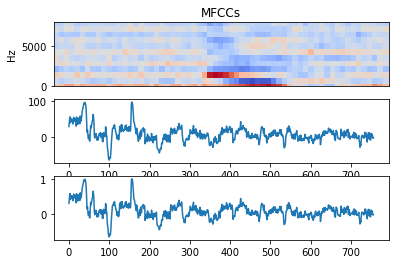

In [5]:
plt.figure()
plt.subplot(311)
librosa.display.specshow(features[0, :].reshape((NUM_MFCC - 1 , -1)),
                         sr=sampling_rate,
                         hop_length=HOP_LENGTH,
                         y_axis='linear', 
                         x_axis='time')
plt.title('MFCCs')
plt.xticks([])
plt.xlabel('')

plt.subplot(312)
plt.plot(features[0, :])

plt.subplot(313)
plt.plot(normed_features[0, :])

## Logistic Regression
This is a multiclass problem. We use scikit learn to learn the classifier.

In [6]:
from sklearn.model_selection import train_test_split # to obtain the train, validation and test split
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score

In [11]:
nb_classes = len(core_words + auxiliary_words)


# Get training, validation and test
num_files = len(filenames)

training_indices = random.sample(range(num_files), int(0.8 * num_files))
training_indices.sort()

test_and_val = list(set(range(num_files)) - set(training_indices))
validation_indices = random.sample(test_and_val, int(0.5 * len(test_and_val)))
test_indices = list(set(test_and_val) - set(validation_indices))
validation_indices.sort()
test_indices.sort()

assert(len(training_indices) + len(validation_indices) + len(test_indices) == num_files)


X_train = normed_features[training_indices, :]
X_val = normed_features[validation_indices, :]
X_test = normed_features[test_indices, :]

# get the targets
all_words = core_words + auxiliary_words
labels = []
for file in filenames:
    labels.append(all_words.index(file.split('/')[0]))
    
y_train = np.array(labels)[training_indices]
y_val = np.array(labels)[validation_indices]
y_test = np.array(labels)[test_indices]

# convert class vectors to binary class matrices
# Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_val = np_utils.to_categorical(y_val, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
# neural net
model = Sequential()
model.add(Dense(512, input_shape=(features.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_val, Y_val))

score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

model.save('models/speech_recog.h5')

In [12]:
y_val

array([ 0,  0,  0, ..., 29, 29, 29])

In [13]:
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

In [14]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
lr_clf.score(X_train, y_train)

0.50123609394313973